# XGBoost&Sobol

## 原版

In [9]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib

from xgboost import XGBRegressor
from SALib.sample import sobol as sobol_sample
from SALib.analyze import sobol
from sklearn.preprocessing import MinMaxScaler

def run_analysis(target_variable, feature_variables_s1_st, feature_pairs_s2, 
                 input_csv_path, output_dir_path, 
                 plot_config,
                 sobol_n_samples=1024, heatmap_colormap="Reds"):
    """
    使用两阶段训练的XGBoost模型进行Sobol敏感性分析，并生成S2热力图。
    """
    # ==========================================================================
    # 1. 路径与字体配置
    # ==========================================================================
    input_csv = input_csv_path
    output_dir = output_dir_path
    
    os.makedirs(output_dir, exist_ok=True)
    
    matplotlib.rcParams['font.family'] = 'sans-serif'
    matplotlib.rcParams['font.sans-serif'] = ['SimSun', 'Times New Roman']
    matplotlib.rcParams['axes.unicode_minus'] = False

    # ==========================================================================
    # 2. 数据准备 (逻辑不变)
    # ==========================================================================
    print(f"--- 步骤 1/5: 正在准备数据... ---")
    s1_vars = set(feature_variables_s1_st)
    s2_vars = set(var for pair in feature_pairs_s2 for var in pair)
    all_feature_vars = sorted(list(s1_vars.union(s2_vars)))
    print(f"    分析将针对以下 {len(all_feature_vars)} 个特征变量进行：{all_feature_vars}")
    print(f"    正在从 {os.path.basename(input_csv)} 加载数据...")
    df_raw = pd.read_csv(input_csv, encoding='utf-8-sig')
    df_all = df_raw[[target_variable] + all_feature_vars].dropna()
    X_all = df_all[all_feature_vars]
    y_all = df_all[target_variable].values
    print(f"    全局数据集准备完成，样本量为: {len(df_all)}")
    fine_tune_regions = ["CHN", "R10CHINA+"]
    df_china = df_raw[df_raw['Region'].isin(fine_tune_regions)][[target_variable] + all_feature_vars].dropna()
    X_china = df_china[all_feature_vars]
    y_china = df_china[target_variable].values
    print(f"    中国区域数据集准备完成，样本量为: {len(df_china)}")

    # ==========================================================================
    # 3. Sobol 敏感性分析
    # ==========================================================================
    print(f"\n--- 步骤 2/5: 正在准备 Sobol 分析... ---")
    scaler = MinMaxScaler()
    scaler.fit(X_all) 
    problem = {
        'num_vars': len(all_feature_vars),
        'names': all_feature_vars,
        'bounds': [[0, 1]] * len(all_feature_vars)
    }
    
    param_values = sobol_sample.sample(problem, sobol_n_samples, calc_second_order=True)
    print(f"    Sobol样本生成完毕，总样本量 (N * (2D + 2)) 为: {param_values.shape[0]} 条")

    # ==========================================================================
    # 4. 两阶段模型训练与预测 (逻辑不变)
    # ==========================================================================
    print(f"\n--- 步骤 3/5: 正在进行两阶段模型训练... ---")
    X_all_scaled = scaler.transform(X_all)
    X_china_scaled = scaler.transform(X_china)
    print("    第一阶段：使用全局样本训练基础模型 (40棵树)...")
    base_model = XGBRegressor(n_estimators=40, max_depth=6, random_state=42, verbosity=0)
    base_model.fit(X_all_scaled, y_all)
    print("    第二阶段：使用中国样本微调模型 (额外20棵树)...")
    final_model = XGBRegressor(n_estimators=20, max_depth=6, random_state=42, verbosity=0)
    final_model.fit(X_china_scaled, y_china, xgb_model=base_model.get_booster())
    print("    最终模型训练完成 (总计60棵树)。")
    print("    正在使用最终模型对Sobol样本进行预测...")
    Y_pred = final_model.predict(param_values)
    print("    正在计算Sobol指数...")
    sobol_result = sobol.analyze(problem, Y_pred, calc_second_order=True, print_to_console=False)
    s1_st_results = pd.DataFrame({
        "变量": all_feature_vars,
        "一阶S1": np.round(sobol_result['S1'], 4),
        "总效ST": np.round(sobol_result['ST'], 4),
    }).sort_values(by="总效ST", ascending=False)
    s1_st_path = os.path.join(output_dir, f"{target_variable}_S1_ST_analysis.csv")
    s1_st_results.to_csv(s1_st_path, index=False, encoding='utf-8-sig')
    print(f"[✔] S1 和 ST 指数已保存至: {s1_st_path}")

    # ==========================================================================
    # 5. S2 交互效应分析与热力图可视化 (逻辑不变)
    # ==========================================================================
    print(f"\n--- 步骤 4/5: 正在处理 S2 指数并生成热力图... ---")
    s2_matrix = sobol_result['S2']
    var_names = problem['names']
    s2_df = pd.DataFrame(s2_matrix, index=var_names, columns=var_names)
    s2_values = []
    for pair in feature_pairs_s2:
        v1, v2 = sorted(pair)
        s2_val = s2_df.loc[v1, v2]
        s2_values.append({"特征对": f"{v1} & {v2}", "S2指数": s2_val})
    if not s2_values:
        print("[!] 未指定有效的S2特征对，跳过S2可视化。")
    else:
        s2_paired_results = pd.DataFrame(s2_values).sort_values(by="S2指数", ascending=False)
        s2_csv_path = os.path.join(output_dir, f"{target_variable}_S2_pairwise_analysis.csv")
        s2_paired_results.to_csv(s2_csv_path, index=False, encoding='utf-8-sig')
        print(f"[✔] 指定特征对的 S2 指数已保存至: {s2_csv_path}")
        unique_s2_vars = sorted(list(set(var for pair in feature_pairs_s2 for var in pair)))
        s2_heatmap_df = pd.DataFrame(np.nan, index=unique_s2_vars, columns=unique_s2_vars)
        for var1, var2 in feature_pairs_s2:
            v1_s, v2_s = sorted((var1, var2))
            s2_val = s2_df.loc[v1_s, v2_s]
            s2_heatmap_df.loc[var1, var2] = s2_val
            s2_heatmap_df.loc[var2, var1] = s2_val
        plt.figure(figsize=plot_config['figure_size'])
        ax = sns.heatmap(
            s2_heatmap_df, cmap=heatmap_colormap, annot=True, fmt=".4f",
            linewidths=.5, annot_kws={'size': plot_config['annot_fontsize'], 'fontweight': 'bold'},
            cbar_kws={'label': ''}
        )
        title_text = f"目标变量 - {target_variable.upper()}"
        plt.title(title_text, fontsize=plot_config['title_fontsize'], fontweight='bold')
        plt.xticks(fontsize=plot_config['tick_label_fontsize'], fontweight='bold', rotation=45, ha='right')
        plt.yticks(fontsize=plot_config['tick_label_fontsize'], fontweight='bold', rotation=0)
        cbar = ax.collections[0].colorbar
        cbar.set_label('S2 指数', fontsize=plot_config['cbar_label_fontsize'], fontweight='bold')
        cbar.ax.tick_params(labelsize=plot_config['cbar_tick_fontsize'])
        for label in cbar.ax.get_yticklabels():
            label.set_fontweight('bold')
        plt.tight_layout()
        heatmap_path = os.path.join(output_dir, f"{target_variable}_S2_heatmap.png")
        plt.savefig(heatmap_path, dpi=300)
        print(f"[✔] S2 指数热力图已保存至: {heatmap_path}")
    
    print(f"\n--- 步骤 5/5: 所有分析任务执行完毕 ---")

# FEI

## 原版

In [10]:
# ==============================================================================
# 主程序执行区 (Main Execution Area)
# ==============================================================================
if __name__ == "__main__":
    
    # 1. 指定输入和输出文件路径
    input_file = r"C:\Users\phc\Desktop\中国模型比较\中国模型比较2\4_机器学习归因\XGBoost\var_attri\data\变量归因_模型归因数据库.csv"
    output_folder = r"C:\Users\phc\Desktop\中国模型比较\中国模型比较2\4_机器学习归因\XGBoost\var_attri\results\验证优化\FEI"

    # 2. 指定目标变量
    target = "fei"

    # 3. 指定主要用于S1和ST分析的特征变量
    features_for_s1_st = ["seeh", "pe", "eced"]

    # 4. 指定要进行S2分析的特征对
    features_for_s2 = [
        ("seeh", "eced"),
        ("pe", "fet"),
        ("eced", "seen")
    ]

    # 5. 指定Sobol分析的基础样本量N
    sobol_N_value = 262144

    # 6. 指定S2热力图的颜色主题
    color_theme = "Greens"

    # 7. --- 修改点：在这里手动传入所有绘图格式参数 ---
    plotting_parameters = {
        # 5. 整个图像的大小, 格式为 (宽度, 高度)，单位为英寸
        'figure_size': (12, 9),
        
        # 1. 图像正上方标题的字体大小
        'title_fontsize': 30,
        
        # 3. 热力图每个色块中数值的字体大小
        'annot_fontsize': 30,
        
        # 4. 横纵坐标上变量名的字体大小
        'tick_label_fontsize': 30,
        
        # 7. 颜色条标题 ("S2 指数") 的字体大小
        'cbar_label_fontsize': 30,
        
        # 6. 颜色条刻度上数字的字体大小
        'cbar_tick_fontsize': 15
    }
    
    # 调用核心分析函数，传入以上所有配置
    run_analysis(
        target_variable=target,
        feature_variables_s1_st=features_for_s1_st,
        feature_pairs_s2=features_for_s2,
        input_csv_path=input_file,
        output_dir_path=output_folder,
        sobol_n_samples=sobol_N_value,
        heatmap_colormap=color_theme,
        plot_config=plotting_parameters # 传入绘图参数字典
    )

--- 步骤 1/5: 正在准备数据... ---
    分析将针对以下 5 个特征变量进行：['eced', 'fet', 'pe', 'seeh', 'seen']
    正在从 变量归因_模型归因数据库.csv 加载数据...
    全局数据集准备完成，样本量为: 25479
    中国区域数据集准备完成，样本量为: 2547

--- 步骤 2/5: 正在准备 Sobol 分析... ---


KeyboardInterrupt: 

# SEEO

--- 步骤 1/5: 正在准备数据... ---
    分析将针对以下 5 个特征变量进行：['csc', 'cscf', 'peowc', 'seebwoc', 'seegwoc']
    正在从 变量归因_模型归因数据库.csv 加载数据...
    全局数据集准备完成，样本量为: 25479
    中国区域数据集准备完成，样本量为: 2547

--- 步骤 2/5: 正在准备 Sobol 分析... ---
    Sobol样本生成完毕，总样本量 (N * (2D + 2)) 为: 3145728 条

--- 步骤 3/5: 正在进行两阶段模型训练... ---
    第一阶段：使用全局样本训练基础模型 (40棵树)...
    第二阶段：使用中国样本微调模型 (额外20棵树)...
    最终模型训练完成 (总计60棵树)。
    正在使用最终模型对Sobol样本进行预测...
    正在计算Sobol指数...


C:\Users\phc\AppData\Roaming\Python\Python310\site-packages\SALib\util\__init__.py:274: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  names = list(pd.unique(groups))


[✔] S1 和 ST 指数已保存至: C:\Users\phc\Desktop\中国模型比较\中国模型比较2\4_机器学习归因\XGBoost\var_attri\results\验证优化\SEEO\seeo_S1_ST_analysis.csv

--- 步骤 4/5: 正在处理 S2 指数并生成热力图... ---
[✔] 指定特征对的 S2 指数已保存至: C:\Users\phc\Desktop\中国模型比较\中国模型比较2\4_机器学习归因\XGBoost\var_attri\results\验证优化\SEEO\seeo_S2_pairwise_analysis.csv
[✔] S2 指数热力图已保存至: C:\Users\phc\Desktop\中国模型比较\中国模型比较2\4_机器学习归因\XGBoost\var_attri\results\验证优化\SEEO\seeo_S2_heatmap.png

--- 步骤 5/5: 所有分析任务执行完毕 ---


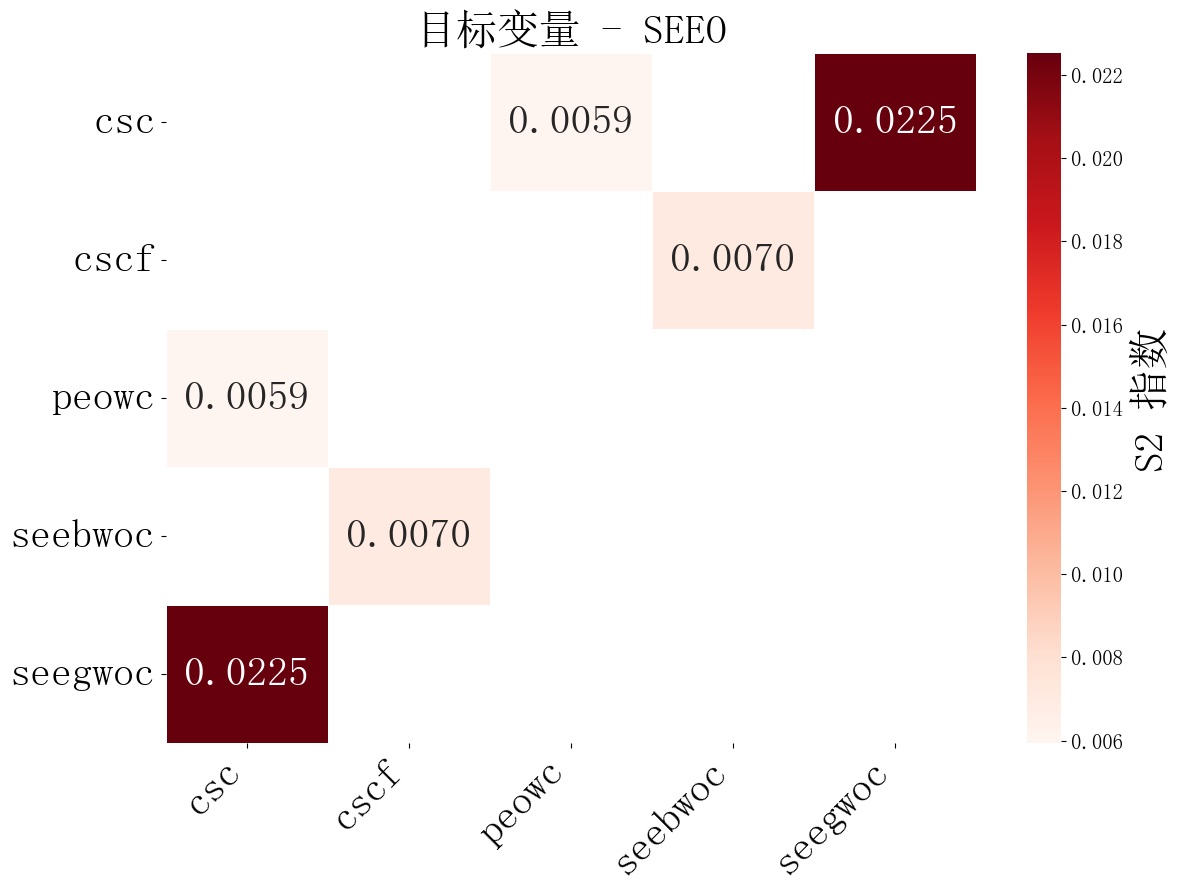

In [ ]:
# ==============================================================================
# 主程序执行区 (Main Execution Area)
# ==============================================================================
if __name__ == "__main__":
    
    # 1. 指定输入和输出文件路径
    input_file = r"C:\Users\phc\Desktop\中国模型比较\中国模型比较2\4_机器学习归因\XGBoost\var_attri\data\变量归因_模型归因数据库.csv"
    output_folder = r"C:\Users\phc\Desktop\中国模型比较\中国模型比较2\4_机器学习归因\XGBoost\var_attri\results\验证优化\SEEO"

    # 2. 指定目标变量
    target = "seeo"

    # 3. 指定主要用于S1和ST分析的特征变量
    features_for_s1_st = ["peowc", "seebwoc", "csc"]

    # 4. 指定要进行S2分析的特征对
    features_for_s2 = [
        ("peowc", "csc"),
        ("seebwoc", "cscf"),
        ("csc", "seegwoc")
    ]

    # 5. 指定Sobol分析的基础样本量N
    sobol_N_value = 262144

    # 6. 指定S2热力图的颜色主题
    color_theme = "Reds"

    # 7. --- 修改点：在这里手动传入所有绘图格式参数 ---
    plotting_parameters = {
        # 5. 整个图像的大小, 格式为 (宽度, 高度)，单位为英寸
        'figure_size': (12, 9),
        
        # 1. 图像正上方标题的字体大小
        'title_fontsize': 30,
        
        # 3. 热力图每个色块中数值的字体大小
        'annot_fontsize': 30,
        
        # 4. 横纵坐标上变量名的字体大小
        'tick_label_fontsize': 30,
        
        # 7. 颜色条标题 ("S2 指数") 的字体大小
        'cbar_label_fontsize': 30,
        
        # 6. 颜色条刻度上数字的字体大小
        'cbar_tick_fontsize': 15
    }
    
    # 调用核心分析函数，传入以上所有配置
    run_analysis(
        target_variable=target,
        feature_variables_s1_st=features_for_s1_st,
        feature_pairs_s2=features_for_s2,
        input_csv_path=input_file,
        output_dir_path=output_folder,
        sobol_n_samples=sobol_N_value,
        heatmap_colormap=color_theme,
        plot_config=plotting_parameters # 传入绘图参数字典
    )

# 合成一张图

In [25]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib

from xgboost import XGBRegressor
from SALib.sample import sobol as sobol_sample
from SALib.analyze import sobol
from sklearn.preprocessing import MinMaxScaler

def run_analysis(target_variable, feature_variables_s1_st, feature_pairs_s2, 
                 input_csv_path, output_dir_path, 
                 plot_config,
                 ax, 
                 sobol_n_samples=1024, heatmap_colormap="Reds"):
    """
    使用两阶段训练的XGBoost模型进行Sobol敏感性分析，并将S2热力图绘制在指定的子图(ax)上。
    """
    # ==========================================================================
    # 1. 路径与字体配置
    # ==========================================================================
    input_csv = input_csv_path
    output_dir = output_dir_path
    
    os.makedirs(output_dir, exist_ok=True)
    
    matplotlib.rcParams['font.family'] = 'sans-serif'
    matplotlib.rcParams['font.sans-serif'] = ['Times New Roman', 'SimSun']
    matplotlib.rcParams['axes.unicode_minus'] = False

    # ==========================================================================
    # 2. 数据准备
    # ==========================================================================
    print(f"--- 步骤 1/5: 正在为目标 [{target_variable.upper()}] 准备数据... ---")
    s1_vars = set(feature_variables_s1_st)
    s2_vars = set(var for pair in feature_pairs_s2 for var in pair)
    all_feature_vars = sorted(list(s1_vars.union(s2_vars)))
    print(f"    分析将针对以下 {len(all_feature_vars)} 个特征变量进行：{all_feature_vars}")
    print(f"    正在从 {os.path.basename(input_csv)} 加载数据...")
    df_raw = pd.read_csv(input_csv, encoding='utf-8-sig')
    df_all = df_raw[[target_variable] + all_feature_vars].dropna()
    X_all = df_all[all_feature_vars]
    y_all = df_all[target_variable].values
    print(f"    全局数据集准备完成，样本量为: {len(df_all)}")
    fine_tune_regions = ["CHN", "R10CHINA+"]
    df_china = df_raw[df_raw['Region'].isin(fine_tune_regions)][[target_variable] + all_feature_vars].dropna()
    X_china = df_china[all_feature_vars]
    y_china = df_china[target_variable].values
    print(f"    中国区域数据集准备完成，样本量为: {len(df_china)}")

    # ==========================================================================
    # 3. Sobol 敏感性分析
    # ==========================================================================
    print(f"\n--- 步骤 2/5: 正在为 [{target_variable.upper()}] 准备 Sobol 分析... ---")
    scaler = MinMaxScaler()
    scaler.fit(X_all) 
    problem = {
        'num_vars': len(all_feature_vars),
        'names': all_feature_vars,
        'bounds': [[0, 1]] * len(all_feature_vars)
    }
    param_values = sobol_sample.sample(problem, sobol_n_samples, calc_second_order=True)
    print(f"    Sobol样本生成完毕，总样本量 (N * (2D + 2)) 为: {param_values.shape[0]} 条")

    # ==========================================================================
    # 4. 两阶段模型训练与预测
    # ==========================================================================
    print(f"\n--- 步骤 3/5: 正在为 [{target_variable.upper()}] 进行两阶段模型训练... ---")
    X_all_scaled = scaler.transform(X_all)
    X_china_scaled = scaler.transform(X_china)
    print("    第一阶段：使用全局样本训练基础模型 (40棵树)...")
    base_model = XGBRegressor(n_estimators=40, max_depth=6, random_state=42, verbosity=0)
    base_model.fit(X_all_scaled, y_all)
    print("    第二阶段：使用中国样本微调模型 (额外20棵树)...")
    final_model = XGBRegressor(n_estimators=20, max_depth=6, random_state=42, verbosity=0)
    final_model.fit(X_china_scaled, y_china, xgb_model=base_model.get_booster())
    print("    最终模型训练完成 (总计60棵树)。")
    print("    正在使用最终模型对Sobol样本进行预测...")
    Y_pred = final_model.predict(param_values)
    print("    正在计算Sobol指数...")
    sobol_result = sobol.analyze(problem, Y_pred, calc_second_order=True, print_to_console=False)
    s1_st_results = pd.DataFrame({
        "变量": all_feature_vars,
        "一阶S1": np.round(sobol_result['S1'], 4),
        "总效ST": np.round(sobol_result['ST'], 4),
    }).sort_values(by="总效ST", ascending=False)
    s1_st_path = os.path.join(output_dir, f"{target_variable}_S1_ST_analysis.csv")
    s1_st_results.to_csv(s1_st_path, index=False, encoding='utf-8-sig')
    print(f"[✔] S1 和 ST 指数已保存至: {s1_st_path}")

    # ==========================================================================
    # 5. S2 交互效应分析与热力图可视化
    # ==========================================================================
    print(f"\n--- 步骤 4/5: 正在为 [{target_variable.upper()}] 处理 S2 指数并生成热力图... ---")
    s2_matrix = sobol_result['S2']
    var_names = problem['names']
    s2_df = pd.DataFrame(s2_matrix, index=var_names, columns=var_names)
    s2_values = []
    for pair in feature_pairs_s2:
        v1, v2 = sorted(pair)
        s2_val = s2_df.loc[v1, v2]
        s2_values.append({"特征对": f"{v1} & {v2}", "S2指数": s2_val})
    if not s2_values:
        print("[!] 未指定有效的S2特征对，跳过S2可视化。")
    else:
        s2_paired_results = pd.DataFrame(s2_values).sort_values(by="S2指数", ascending=False)
        s2_csv_path = os.path.join(output_dir, f"{target_variable}_S2_pairwise_analysis.csv")
        s2_paired_results.to_csv(s2_csv_path, index=False, encoding='utf-8-sig')
        print(f"[✔] 指定特征对的 S2 指数已保存至: {s2_csv_path}")
        
        unique_s2_vars = sorted(list(set(var for pair in feature_pairs_s2 for var in pair)))
        s2_heatmap_df = pd.DataFrame(np.nan, index=unique_s2_vars, columns=unique_s2_vars)
        for var1, var2 in feature_pairs_s2:
            v1_s, v2_s = sorted((var1, var2))
            s2_val = s2_df.loc[v1_s, v2_s]
            s2_heatmap_df.loc[var1, var2] = s2_val
            s2_heatmap_df.loc[var2, var1] = s2_val
        
        sns.heatmap(
            s2_heatmap_df, cmap=heatmap_colormap, annot=True, fmt=".4f",
            linewidths=.5, annot_kws={'size': plot_config['annot_fontsize'], 
                                      'fontweight': 'bold'},
            cbar_kws={'label': ''},
            ax=ax
        )
        
        # --- 修改点 1: 移除标题中的"目标变量 - " ---
        title_text = f"{target_variable.upper()}"
        ax.set_title(title_text, fontsize=plot_config['title_fontsize'], fontweight='bold')
        
        ax.tick_params(axis='x', labelsize=plot_config['tick_label_fontsize'], labelrotation=45)
        ax.tick_params(axis='y', labelsize=plot_config['tick_label_fontsize'], labelrotation=0)
        
        for label in ax.get_xticklabels(): 
            label.set_fontweight('bold')
        for label in ax.get_yticklabels(): 
            label.set_fontweight('bold')

        cbar = ax.collections[0].colorbar
        # --- 修改点 2: 移除颜色条的标题 ---
        # cbar.set_label('S2 指数', fontsize=plot_config['cbar_label_fontsize'], fontweight='bold')
        
        cbar.ax.tick_params(labelsize=plot_config['cbar_tick_fontsize'])
        for label in cbar.ax.get_yticklabels():
            label.set_fontweight('bold')
    
    print(f"    绘图完成: [{target_variable.upper()}]")



In [28]:
# ==============================================================================
# 主程序执行区 (Main Execution Area)
# ==============================================================================
if __name__ == "__main__":
    
    input_file = r"C:\Users\phc\Desktop\中国模型比较\中国模型比较2\4_机器学习归因\XGBoost\var_attri\data\变量归因_模型归因数据库.csv"
    output_folder = r"C:\Users\phc\Desktop\中国模型比较\中国模型比较2\4_机器学习归因\XGBoost\var_attri\results\验证优化\FEI_SEEO"

    fei_config = {
        "target": "fei", "features_for_s1_st": ["seeh", "pe", "eced"],
        "features_for_s2": [("seeh", "eced"), ("pe", "fet"), ("eced", "seen")],
        "sobol_N_value": 32768, "color_theme": "Greens", "subplot_label": "a"
    }
    
    seeo_config = {
        "target": "seeo", "features_for_s1_st": ["peowc", "seebwoc", "csc"],
        "features_for_s2": [("peowc", "csc"), ("seebwoc", "cscf"), ("csc", "seegwoc")],
        "sobol_N_value": 32768, "color_theme": "Reds", "subplot_label": "b"
    }

    analyses_to_run = [fei_config, seeo_config]
    
    plotting_parameters = {
        'figure_size': (12, 9), 'title_fontsize': 30, 'annot_fontsize': 30,
        'tick_label_fontsize': 30, 'cbar_label_fontsize': 30, 'cbar_tick_fontsize': 20
    }
    
    fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(14, 20))

    for i, config in enumerate(analyses_to_run):
        print(f"\n{'='*30} 开始分析任务 {i+1}/{len(analyses_to_run)}: 目标变量 {config['target'].upper()} {'='*30}")
        
        run_analysis(
            target_variable=config['target'],
            feature_variables_s1_st=config['features_for_s1_st'],
            feature_pairs_s2=config['features_for_s2'],
            input_csv_path=input_file,
            output_dir_path=output_folder,
            sobol_n_samples=config['sobol_N_value'],
            heatmap_colormap=config['color_theme'],
            plot_config=plotting_parameters,
            ax=axes[i]
        )
        
        axes[i].text(-0.1, 1.05, config['subplot_label'], 
                     transform=axes[i].transAxes,
                     fontsize=30, fontweight='bold', va='top', ha='left')

    print("\n[✔] 所有分析和绘图完成，正在保存最终组合图...")
    fig.tight_layout(pad=3.0)
    
    final_image_path = os.path.join(output_folder, "FEI_SEEO_Combined_Analysis.png")
    plt.savefig(final_image_path, dpi=300)
    plt.close()

    print(f"[✔] 组合图已成功保存至: {final_image_path}")


============================== 开始分析任务 1/2: 目标变量 FEI ==============================
--- 步骤 1/5: 正在为目标 [FEI] 准备数据... ---
    分析将针对以下 5 个特征变量进行：['eced', 'fet', 'pe', 'seeh', 'seen']
    正在从 变量归因_模型归因数据库.csv 加载数据...
    全局数据集准备完成，样本量为: 25479
    中国区域数据集准备完成，样本量为: 2547

--- 步骤 2/5: 正在为 [FEI] 准备 Sobol 分析... ---
    Sobol样本生成完毕，总样本量 (N * (2D + 2)) 为: 393216 条

--- 步骤 3/5: 正在为 [FEI] 进行两阶段模型训练... ---
    第一阶段：使用全局样本训练基础模型 (40棵树)...
    第二阶段：使用中国样本微调模型 (额外20棵树)...
    最终模型训练完成 (总计60棵树)。
    正在使用最终模型对Sobol样本进行预测...
    正在计算Sobol指数...


C:\Users\phc\AppData\Roaming\Python\Python310\site-packages\SALib\util\__init__.py:274: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  names = list(pd.unique(groups))


[✔] S1 和 ST 指数已保存至: C:\Users\phc\Desktop\中国模型比较\中国模型比较2\4_机器学习归因\XGBoost\var_attri\results\验证优化\FEI_SEEO\fei_S1_ST_analysis.csv

--- 步骤 4/5: 正在为 [FEI] 处理 S2 指数并生成热力图... ---
[✔] 指定特征对的 S2 指数已保存至: C:\Users\phc\Desktop\中国模型比较\中国模型比较2\4_机器学习归因\XGBoost\var_attri\results\验证优化\FEI_SEEO\fei_S2_pairwise_analysis.csv
    绘图完成: [FEI]

============================== 开始分析任务 2/2: 目标变量 SEEO ==============================
--- 步骤 1/5: 正在为目标 [SEEO] 准备数据... ---
    分析将针对以下 5 个特征变量进行：['csc', 'cscf', 'peowc', 'seebwoc', 'seegwoc']
    正在从 变量归因_模型归因数据库.csv 加载数据...
    全局数据集准备完成，样本量为: 25479
    中国区域数据集准备完成，样本量为: 2547

--- 步骤 2/5: 正在为 [SEEO] 准备 Sobol 分析... ---
    Sobol样本生成完毕，总样本量 (N * (2D + 2)) 为: 393216 条

--- 步骤 3/5: 正在为 [SEEO] 进行两阶段模型训练... ---
    第一阶段：使用全局样本训练基础模型 (40棵树)...
    第二阶段：使用中国样本微调模型 (额外20棵树)...
    最终模型训练完成 (总计60棵树)。
    正在使用最终模型对Sobol样本进行预测...
    正在计算Sobol指数...


C:\Users\phc\AppData\Roaming\Python\Python310\site-packages\SALib\util\__init__.py:274: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  names = list(pd.unique(groups))


[✔] S1 和 ST 指数已保存至: C:\Users\phc\Desktop\中国模型比较\中国模型比较2\4_机器学习归因\XGBoost\var_attri\results\验证优化\FEI_SEEO\seeo_S1_ST_analysis.csv

--- 步骤 4/5: 正在为 [SEEO] 处理 S2 指数并生成热力图... ---
[✔] 指定特征对的 S2 指数已保存至: C:\Users\phc\Desktop\中国模型比较\中国模型比较2\4_机器学习归因\XGBoost\var_attri\results\验证优化\FEI_SEEO\seeo_S2_pairwise_analysis.csv
    绘图完成: [SEEO]

[✔] 所有分析和绘图完成，正在保存最终组合图...
[✔] 组合图已成功保存至: C:\Users\phc\Desktop\中国模型比较\中国模型比较2\4_机器学习归因\XGBoost\var_attri\results\验证优化\FEI_SEEO\FEI_SEEO_Combined_Analysis.png
